In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, chi2, kstwobign, ks_2samp, cauchy, logistic

import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from scipy.special import eval_sh_legendre
from typing import List
from tqdm import tqdm
from typing import *
import plotly.express as px

# Utils

In [2]:
def phi_1(x):
    return np.sqrt(3)*(2*x - 1)

def phi_2(x):
    return np.sqrt(48) * (0.25 - abs(x - 0.5))

In [3]:
def t_statistic(m, n, phi, X, Y):
    N = m + n
    ranked = np.array(pd.DataFrame(np.hstack([X,Y])).rank()).flatten()
    ranked_X = ranked[:m]
    ranked_Y = ranked[m:]
    sum_1 = sum(phi((ranked_X - 0.5) / N))
    sum_2 = sum(phi((ranked_Y - 0.5) / N))
    return np.sqrt(m*n/N) * (1/m * sum_1 - 1/n * sum_2)

def cum_dst(sample, x):
    n = sample.shape[0]
    return sample[sample <= x].shape[0] / n

def ks_statistics(m, n, X, Y):
    N = m + n
    ordered_x = np.sort(X)
    ordered_y = np.sort(Y)
    sup = 0

    for i in range(ordered_x.shape[0]):
        x_i = ordered_x[i]

        if i == 0:
            x_j = -np.inf
        else:
            x_j = ordered_x[i -1]

        pot_sup = max(
            abs(cum_dst(X, x_i) - cum_dst(Y, x_j)),
            abs(cum_dst(X, x_i) - cum_dst(Y, x_i)),
        )

        sup = max(pot_sup, sup)

    for i in range(ordered_y.shape[0]):
        y_i = ordered_y[i]

        if i == 0:
            y_j = -np.inf
        else:
            y_j = ordered_y[i -1]

        pot_sup = max(
            abs(cum_dst(Y, y_j) - cum_dst(Y, y_i)),
            abs(cum_dst(Y, y_i) - cum_dst(Y, y_i)),
        )

        sup = max(pot_sup, sup)

    res = np.sqrt(m*n / N) * sup
    return res


# EX 1

In [4]:
n = 20
m = 20
W_results = []
AB_results = []
L_results = []
KS_results = []
for _ in range(10000):
    X = np.random.normal(size=m)
    Y = np.random.normal(size=n)
    w, ab = t_statistic(m, n, phi_1, X, Y), t_statistic(m, n, phi_2, X, Y)
    ks = ks_statistics(m, n, X, Y) 
    #ks = np.sqrt(n*m / (n+m)) * ks_2samp(X,Y).statistic #

    W_results.append(w**2)
    AB_results.append(ab**2)
    L_results.append(w**2 + ab**2)
    KS_results.append(ks)

theoretical = chi2.ppf(0.95, 1)
AB_critical = sorted(AB_results)[9499]
W_critical = sorted(W_results)[9499]
L_critical = sorted(L_results)[9499]
KS_critical = sorted(KS_results)[9499]

print(f"Standard normal 0.95-quantile: {theoretical}")
print(f"Wilcoxon test 0.95-quantile: {W_critical}")
print(f"Ansari-Bradley test 0.95-quantile: {AB_critical}\n")

theoretical = chi2.ppf(0.95, 2)
print(f"Chi squared with 2 df 0.95-quantile: {theoretical}")
print(f"Lapage test 0.95-quantile: {L_critical}\n")

theoretical = kstwobign.ppf(0.95)
print(f"KS 0.95-quantile: {theoretical}")
print(f"KS test 0.95-quantile: {KS_critical}")

Standard normal 0.95-quantile: 3.841458820694124
Wilcoxon test 0.95-quantile: 3.887999999999999
Ansari-Bradley test 0.95-quantile: 3.888000000000001

Chi squared with 2 df 0.95-quantile: 5.991464547107979
Lapage test 0.95-quantile: 6.01275

KS 0.95-quantile: 1.3580986393225505
KS test 0.95-quantile: 1.264911064067352


# EX 2

In [11]:
def make_experiment(func, params, n, m):
    cr_w = chi2.ppf(0.95, 1)
    cr_ab = chi2.ppf(0.95, 1)
    cr_l = chi2.ppf(0.95, 2)
    cr_ks = kstwobign.ppf(0.95)
    
    test_statistics = {
        'scale': [],
        'shift' : [],
        'Wilcoxon' : [],
        'Ansari-Bradley' : [],
        'Lepage' : [],
        'Kolmogorov-Smirnov' : [],
    }
    powers = []
    for x_params,y_params in params:
        w,ab,l,ks = [],[],[],[]
        
        for i in tqdm(range(10000)):
            X = func(size=m, loc = x_params[0], scale = x_params[1])
            Y = func(size=m, loc = y_params[0], scale = y_params[1])
            w_s, ab_s = t_statistic(m, n, phi_1, X, Y), t_statistic(m, n, phi_2, X, Y)

            w.append(w_s**2)
            ab.append(ab_s**2)
            l.append(w_s**2 + ab_s**2)
            ks.append(ks_statistics(m, n, X, Y))

        powers.append([y_params[0], y_params[1], 'Wilcoxon', sum(w > cr_w) / len(w)])
        powers.append([y_params[0], y_params[1], 'Ansari-Bradley', sum(ab > cr_ab) / len(ab)])
        powers.append([y_params[0], y_params[1], 'Lepage', sum(l > cr_l) / len(l)])
        powers.append([y_params[0], y_params[1], 'Kolmogorov-Smirnov', sum(ks > cr_ks) / len(ks)])

        test_statistics['shift'].append(y_params[0])
        test_statistics['scale'].append(y_params[1])
        test_statistics['Wilcoxon'].append(ks[0])
        test_statistics['Ansari-Bradley'].append(ab[0])
        test_statistics['Lepage'].append(l[0])
        test_statistics['Kolmogorov-Smirnov'].append(ks[0])

    return pd.DataFrame(test_statistics), pd.DataFrame(powers, columns=['shift', 'scale', 'test', 'power'])
        
        

## a)

In [12]:
t_stat, powers = make_experiment(
    func=norm.rvs,
    params=[
        ([0, 1], [0.2, 1.0]), 
        ([0, 1], [0.4, 1.0]), 
        ([0, 1], [0.6, 1.0]),
        ([0, 1], [0.8, 1.0]), 
        ([0, 1], [1.0, 1.0]), 
        ([0, 1], [1.2, 1.0]),
        ([0, 1], [1.4, 1.0])
    ],
    n=20,
    m=20
    )

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:10<00:00, 967.78it/s]


In [13]:
t_stat

,scale,shift,Wilcoxon,Ansari-Bradley,Lepage,Kolmogorov-Smirnov
0,1.0,0.2,0.948683,2.028000e+00,2.11875,0.948683
1,1.0,0.4,0.948683,2.565820e-32,0.19200,0.948683
2,1.0,0.6,2.529822,3.630000e-01,21.53100,2.529822
3,1.0,0.8,1.423025,5.070000e-01,8.00700,1.423025
4,1.0,1.0,2.213594,1.587000e+00,14.26200,2.213594
5,1.0,1.2,1.739253,1.470000e-01,9.72375,1.739253
6,1.0,1.4,1.739253,7.680000e-01,9.51600,1.739253


In [17]:
powers.head()

,shift,scale,test,power
0,0.2,1.0,Wilcoxon,0.0982
1,0.2,1.0,Ansari-Bradley,0.0525
2,0.2,1.0,Lepage,0.0813
3,0.2,1.0,Kolmogorov-Smirnov,0.1177
4,0.4,1.0,Wilcoxon,0.2318


In [36]:
print("Normal distribution with respective shift and scale parameters")
fig = px.line(
    powers.astype({
        "shift": np.float64, "scale": np.float64, "power": np.float64, "test": str
    }), 
    x='shift', 
    y='power', 
    color='test', 
)
fig.show()

Normal distribution with respective shift and scale parameters


## b)

In [40]:
t_stat, powers = make_experiment(
    func=logistic.rvs,
    params=[
        ([0, 1], [0.2, 1.0]), ([0, 1], [0.4, 1.0]), ([0, 1], [0.6, 1.0]),
        ([0, 1], [0.8, 1.0]), ([0, 1], [1.0, 1.0]), ([0, 1], [1.2, 1.0]),
        ([0, 1], [1.4, 1.0])
    ],
    n=20,
    m=20
    )

In [41]:
t_stat

,scale,shift,Wilcoxon,Ansari-Bradley,Lepage,Kolmogorov-Smirnov
0,1.0,0.2,1.106797,1.587,4.56375,1.106797
1,1.0,0.4,1.739253,0.243,7.74300,1.739253
2,1.0,0.6,0.948683,3.267,3.26775,0.948683
3,1.0,0.8,1.264911,0.867,3.13575,1.264911
4,1.0,1.0,1.897367,0.243,9.31800,1.897367
5,1.0,1.2,1.423025,0.075,2.77500,1.423025
6,1.0,1.4,1.106797,2.028,3.54675,1.106797


Logistic distribution with respective shift and scale parameters


<AxesSubplot: xlabel='shift', ylabel='power'>

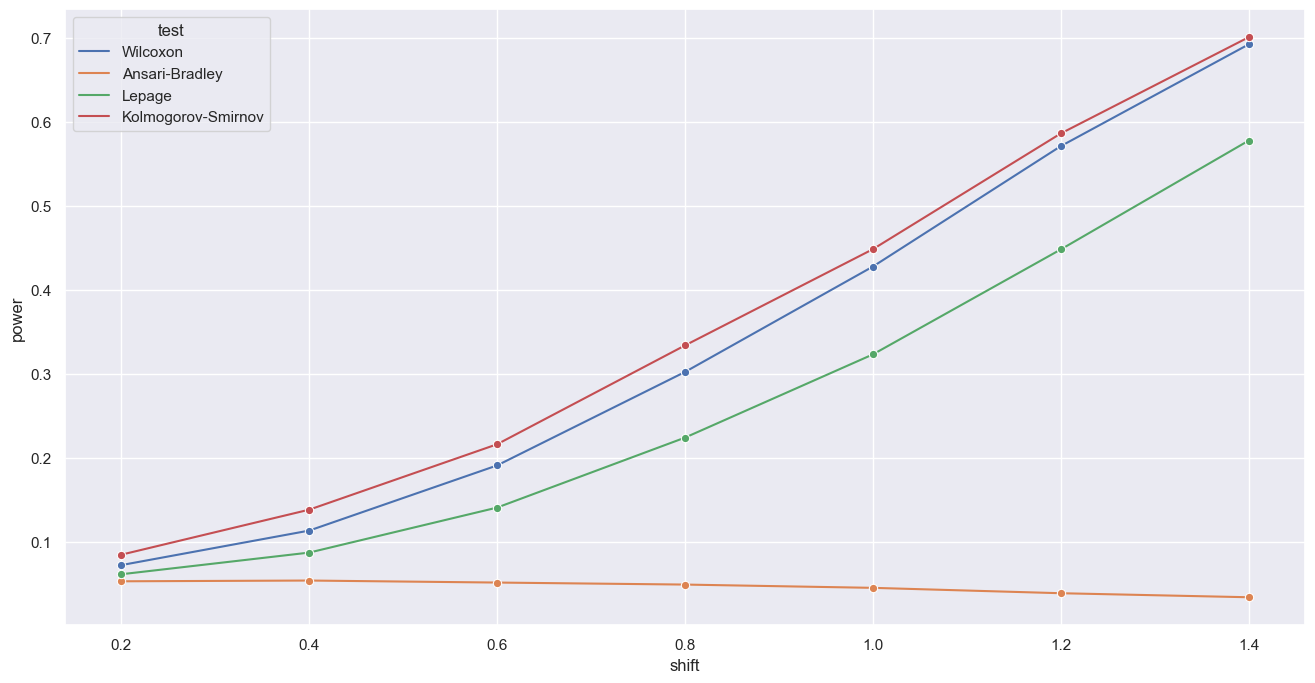

In [42]:
print("Logistic distribution with respective shift and scale parameters")
sns.lineplot(data=powers, x='shift', y='power', hue='test', marker='o')

## c)

In [43]:
t_stat, powers = make_experiment(
    func=cauchy.rvs,
    params=[
        ([0, 1], [0.0, 1.0]), ([0, 1], [0.5, 1.0]), ([0, 1], [1.0, 1.0]),
        ([0, 1], [1.5, 1.0]), ([0, 1], [2.0, 1.0]), ([0, 1], [2.5, 1.0]),
        ([0, 1], [3.0, 1.0])
    ],
    n=20,
    m=20
    )

In [44]:
t_stat

,scale,shift,Wilcoxon,Ansari-Bradley,Lepage,Kolmogorov-Smirnov
0,1.0,0.0,1.423025,10.443,10.47000,1.423025
1,1.0,0.5,1.106797,0.147,2.41575,1.106797
2,1.0,1.0,1.106797,1.587,2.55900,1.106797
3,1.0,1.5,1.423025,0.027,3.09900,1.423025
4,1.0,2.0,2.371708,3.468,10.96800,2.371708
5,1.0,2.5,2.687936,3.267,18.39000,2.687936
6,1.0,3.0,2.371708,0.003,11.16600,2.371708


Cauchy distribution with respective shift and scale parameters


<AxesSubplot: xlabel='shift', ylabel='power'>

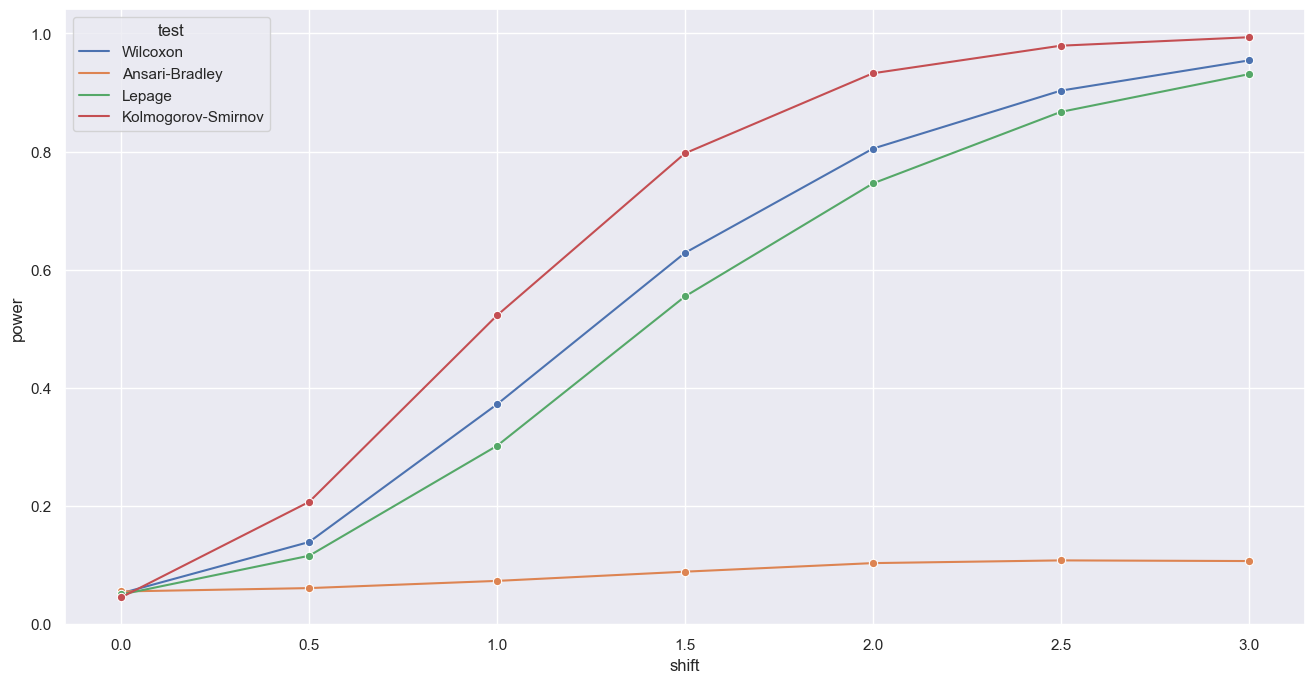

In [45]:
print("Cauchy distribution with respective shift and scale parameters")
sns.lineplot(data=powers, x='shift', y='power', hue='test', marker='o')

# EX 3

## a)

In [46]:
t_stat, powers = make_experiment(
    func=norm.rvs,
    params=[
        ([0, 1], [0, 1.0]), ([0, 1], [0, 1.5]), ([0, 1], [0, 2.0]),
        ([0, 1], [0, 2.5]), ([0, 1], [0, 3.0]), ([0, 1], [0, 3.5]),
        ([0, 1], [0, 4.0])
    ],
    n=20,
    m=20
    )

In [47]:
t_stat

,scale,shift,Wilcoxon,Ansari-Bradley,Lepage,Kolmogorov-Smirnov
0,1.0,0,0.948683,0.432,2.53875,0.948683
1,1.5,0,0.632456,0.768,1.31475,0.632456
2,2.0,0,1.423025,2.028,5.49600,1.423025
3,2.5,0,0.790569,2.883,3.75000,0.790569
4,3.0,0,1.264911,3.267,6.05775,1.264911
5,3.5,0,1.264911,8.112,8.61900,1.264911
6,4.0,0,1.423025,10.443,14.11800,1.423025


Normal distribution with respective shift and scale parameters


<AxesSubplot: xlabel='scale', ylabel='power'>

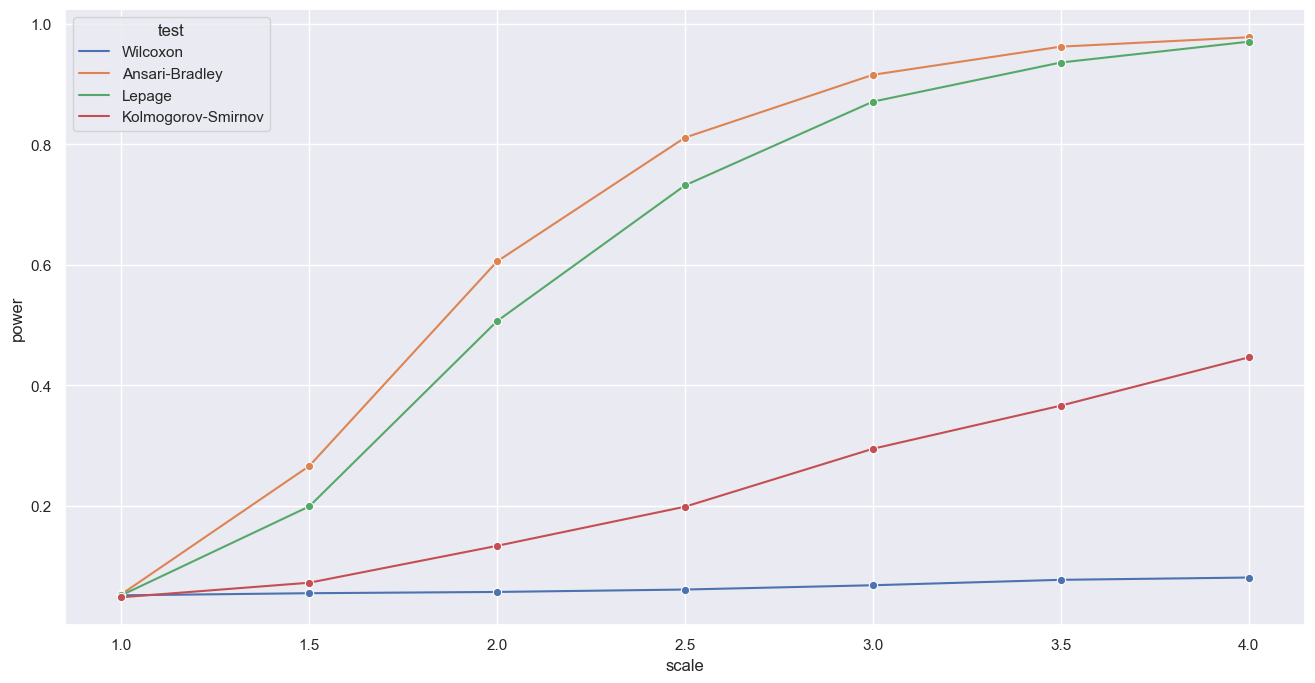

In [48]:
print("Normal distribution with respective shift and scale parameters")
sns.lineplot(data=powers, x='scale', y='power', hue='test', marker='o')

## b)

In [49]:
t_stat, powers = make_experiment(
    func=logistic.rvs,
    params=[
        ([0, 1], [0, 1.0]), ([0, 1], [0, 1.5]), ([0, 1], [0, 2.0]),
        ([0, 1], [0, 2.5]), ([0, 1], [0, 3.0]), ([0, 1], [0, 3.5]),
        ([0, 1], [0, 4.0])
    ],
    n=20,
    m=20
    )

In [50]:
t_stat

,scale,shift,Wilcoxon,Ansari-Bradley,Lepage,Kolmogorov-Smirnov
0,1.0,0,0.948683,0.432,4.00275,0.948683
1,1.5,0,0.790569,3.468,3.59475,0.790569
2,2.0,0,0.632456,3.267,3.41400,0.632456
3,2.5,0,1.423025,4.800,7.06875,1.423025
4,3.0,0,0.948683,8.427,9.05775,0.948683
5,3.5,0,1.106797,14.700,15.03075,1.106797
6,4.0,0,1.423025,12.288,13.80675,1.423025


Logistic distribution with respective shift and scale parameters


<AxesSubplot: xlabel='scale', ylabel='power'>

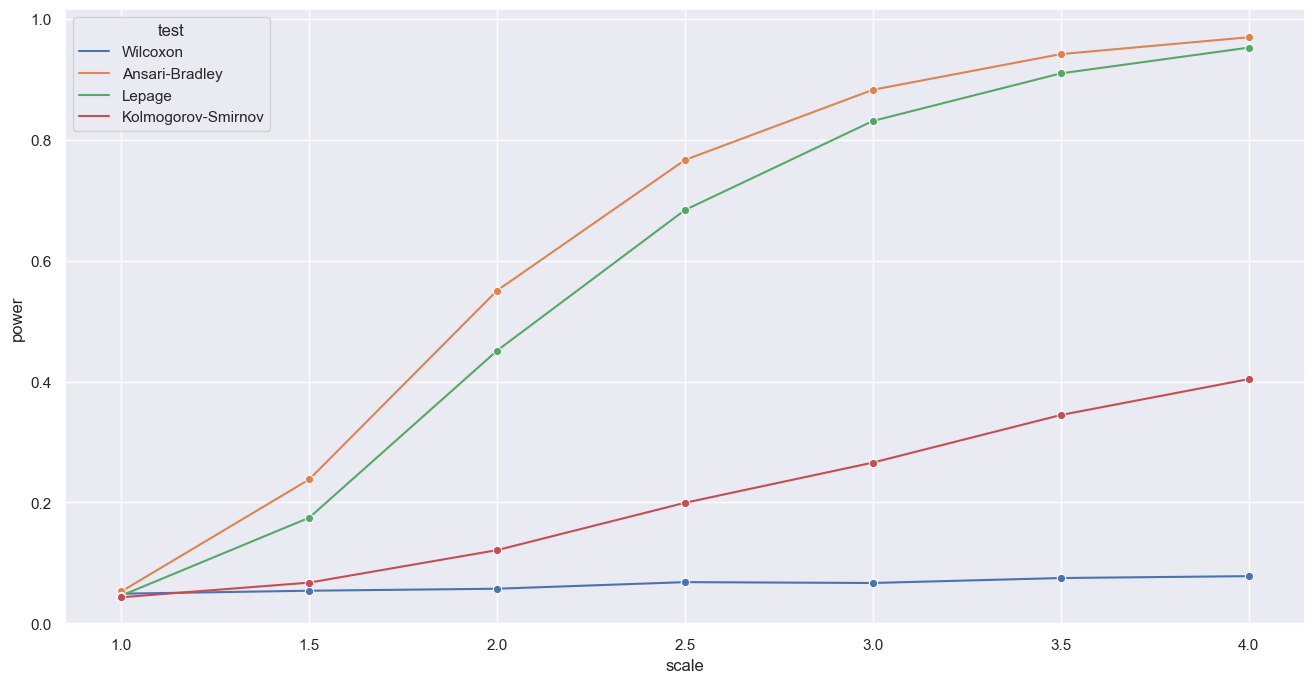

In [51]:
print("Logistic distribution with respective shift and scale parameters")
sns.lineplot(data=powers, x='scale', y='power', hue='test', marker='o')

## c)

In [52]:
t_stat, powers = make_experiment(
    func=cauchy.rvs,
    params=[
        ([0, 1], [0, 1.0]), ([0, 1], [0, 2.0]), ([0, 1], [0, 3.0]),
        ([0, 1], [0, 4.0]), ([0, 1], [0, 5.0]), ([0, 1], [0, 6.0]),
        ([0, 1], [0, 7.0])
    ],
    n=20,
    m=20
    )

In [53]:
t_stat

,scale,shift,Wilcoxon,Ansari-Bradley,Lepage,Kolmogorov-Smirnov
0,1.0,0,0.474342,0.003,0.03000,0.474342
1,2.0,0,0.474342,0.108,0.78300,0.474342
2,3.0,0,1.264911,5.547,6.05400,1.264911
3,4.0,0,1.423025,14.283,14.87100,1.423025
4,5.0,0,1.423025,6.075,7.80300,1.423025
5,6.0,0,1.106797,10.800,11.13075,1.106797
6,7.0,0,1.581139,12.675,13.75800,1.581139


Cauchy distribution with respective shift and scale parameters


<AxesSubplot: xlabel='scale', ylabel='power'>

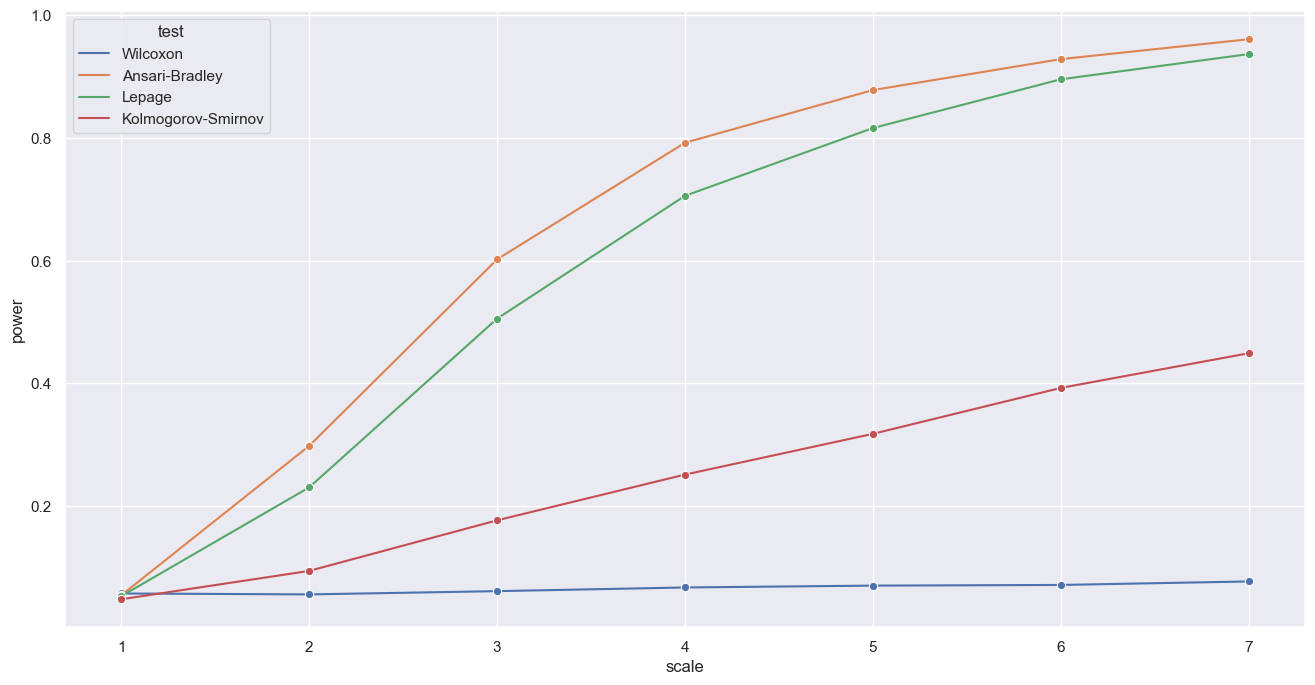

In [54]:
print("Cauchy distribution with respective shift and scale parameters")
sns.lineplot(data=powers, x='scale', y='power', hue='test', marker='o')

# EX 4

## a)

In [55]:
t_stat, powers = make_experiment(
    func=norm.rvs,
    params=[
        ([0, 1], [0.2, 1.0]), ([0, 1], [0.4, 1.5]), ([0, 1], [0.6, 2.0]),
        ([0, 1], [0.8, 2.5]), ([0, 1], [1.0, 3.0]), ([0, 1], [1.2, 3.5]),
        ([0, 1], [1.4, 4.0])
    ],
    n=20,
    m=20
    )

In [56]:
t_stat

,scale,shift,Wilcoxon,Ansari-Bradley,Lepage,Kolmogorov-Smirnov
0,1.0,0.2,0.790569,1.083000e+00,1.11000,0.790569
1,1.5,0.4,0.948683,3.728600e-32,2.79075,0.948683
2,2.0,0.6,1.264911,7.803000e+00,8.19975,1.264911
3,2.5,0.8,1.581139,1.598700e+01,16.45575,1.581139
4,3.0,1.0,1.581139,4.800000e+00,9.13200,1.581139
5,3.5,1.2,1.264911,1.778700e+01,17.79375,1.264911
6,4.0,1.4,1.897367,1.825200e+01,21.82275,1.897367


Normal distribution with respective shift and scale parameters


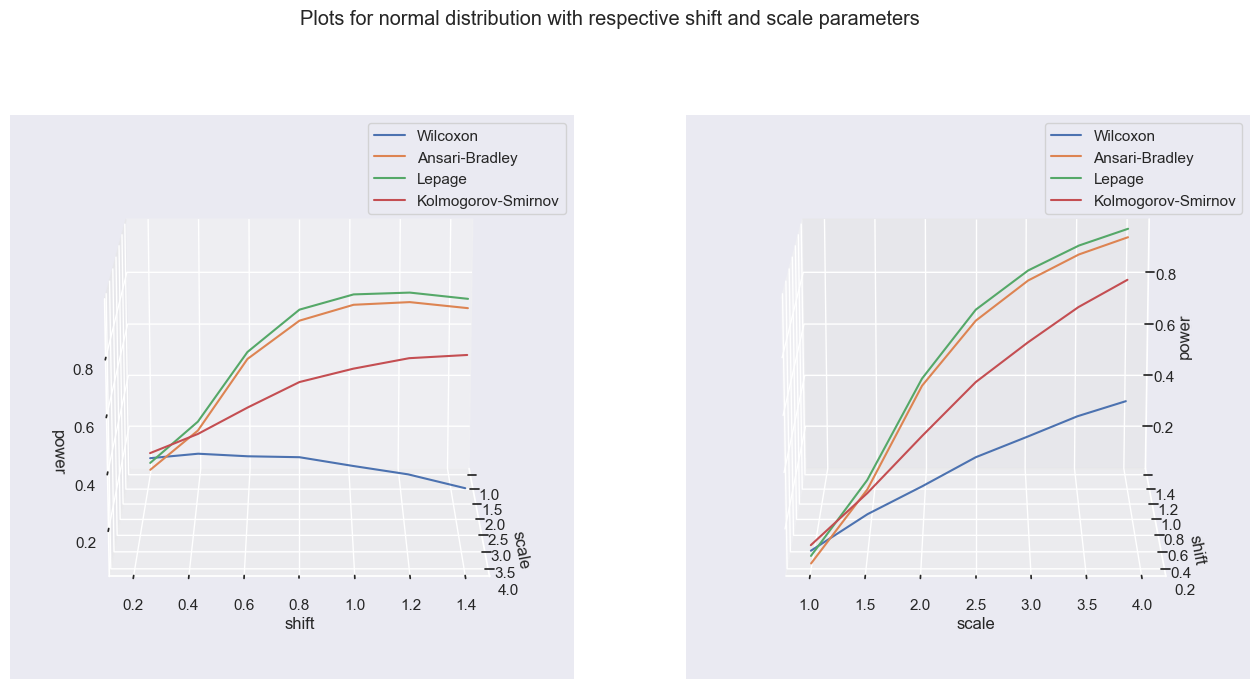

In [57]:
print("Normal distribution with respective shift and scale parameters")
#ax = plt.figure().add_subplot(projection='3d')
fig, axs = plt.subplots(1, 2, subplot_kw={"projection": "3d"})
for i in range(2):
    for test in ['Wilcoxon', 'Ansari-Bradley', 'Lepage', 'Kolmogorov-Smirnov']:
        data = powers[powers.test == test]
        x = list(data.scale)
        y = list(data['shift'])
        z = list(data.power)
        axs[i].plot(x, y, z, label=test)

    axs[i].legend()
    axs[i].set_xlabel('scale')
    axs[i].set_ylabel('shift')
    axs[i].set_zlabel('power')
    axs[i].view_init(elev=15., azim=i*-90, roll=0)

fig.suptitle(f"Plots for normal distribution with respective shift and scale parameters")
plt.show()

## b)

In [58]:
t_stat, powers = make_experiment(
    func=logistic.rvs,
    params=[
        ([0, 1], [0.2, 1.0]), ([0, 1], [0.4, 1.5]), ([0, 1], [0.6, 2.0]),
        ([0, 1], [0.8, 2.5]), ([0, 1], [1.0, 3.0]), ([0, 1], [1.2, 3.5]),
        ([0, 1], [1.4, 4.0])
    ],
    n=20,
    m=20
    )

In [59]:
t_stat

,scale,shift,Wilcoxon,Ansari-Bradley,Lepage,Kolmogorov-Smirnov
0,1.0,0.2,0.632456,4.800,5.43075,0.632456
1,1.5,0.4,0.632456,0.027,0.65775,0.632456
2,2.0,0.6,0.474342,0.108,0.47100,0.474342
3,2.5,0.8,0.948683,9.747,9.74775,0.948683
4,3.0,1.0,1.106797,4.332,4.60275,1.106797
5,3.5,1.2,1.897367,11.532,15.63900,1.897367
6,4.0,1.4,1.423025,13.068,13.23675,1.423025


Logistic distribution with respective shift and scale parameters


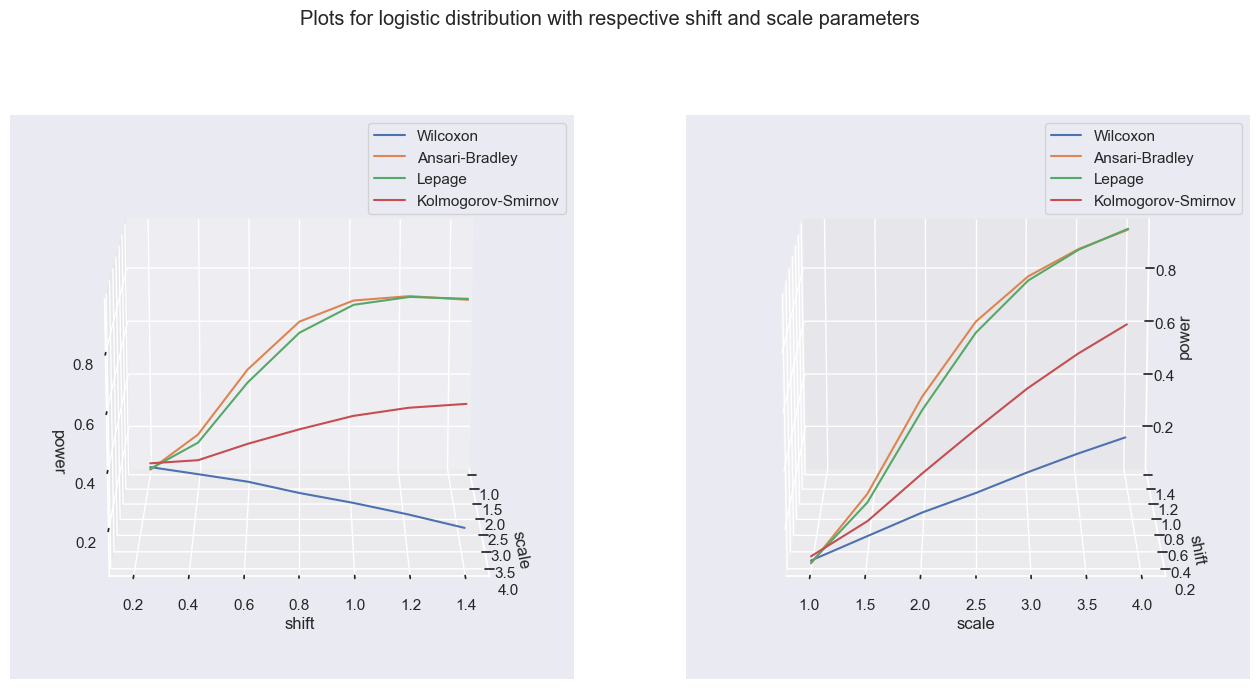

In [60]:
print("Logistic distribution with respective shift and scale parameters")
#ax = plt.figure().add_subplot(projection='3d')
fig, axs = plt.subplots(1, 2, subplot_kw={"projection": "3d"})
for i in range(2):
    for test in ['Wilcoxon', 'Ansari-Bradley', 'Lepage', 'Kolmogorov-Smirnov']:
        data = powers[powers.test == test]
        x = list(data.scale)
        y = list(data['shift'])
        z = list(data.power)
        axs[i].plot(x, y, z, label=test)

    axs[i].legend()
    axs[i].set_xlabel('scale')
    axs[i].set_ylabel('shift')
    axs[i].set_zlabel('power')
    axs[i].view_init(elev=15., azim=i*-90, roll=0)

fig.suptitle(f"Plots for logistic distribution with respective shift and scale parameters")
plt.show()

## c)

In [61]:
t_stat, powers = make_experiment(
    func=cauchy.rvs,
    params=[
        ([0, 1], [0, 1.0]), ([0, 1], [0.5, 2.0]), ([0, 1], [1.0, 3.0]),
        ([0, 1], [1.5, 4.0]), ([0, 1], [2.0, 5.0]), ([0, 1], [2.5, 6.0]),
        ([0, 1], [3.0, 7.0])
    ],
    n=20,
    m=20
    )

In [62]:
t_stat

,scale,shift,Wilcoxon,Ansari-Bradley,Lepage,Kolmogorov-Smirnov
0,1.0,0.0,0.948683,4.332,4.42275,0.948683
1,2.0,0.5,1.423025,7.203,8.12175,1.423025
2,3.0,1.0,1.739253,0.867,5.78775,1.739253
3,4.0,1.5,0.948683,8.427,8.48775,0.948683
4,5.0,2.0,1.581139,5.292,7.64400,1.581139
5,6.0,2.5,2.529822,8.112,20.01900,2.529822
6,7.0,3.0,1.581139,19.200,19.83075,1.581139


Cauchy distribution with respective shift and scale parameters


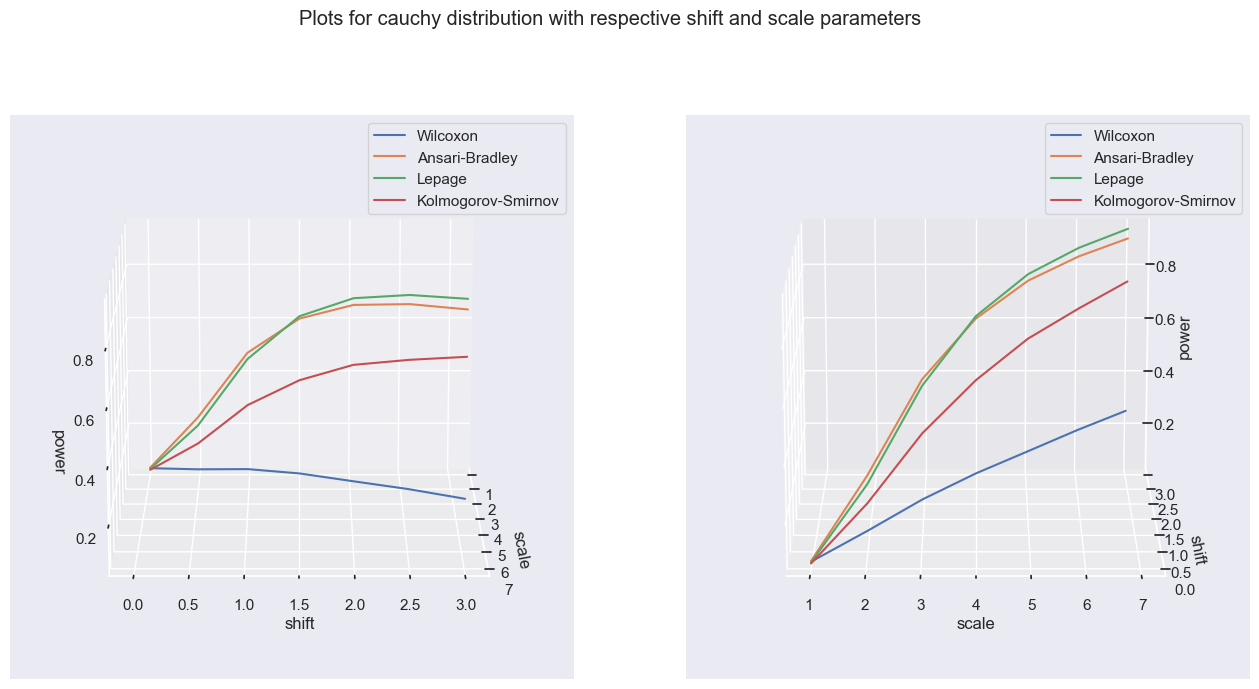

In [63]:
print("Cauchy distribution with respective shift and scale parameters")
#ax = plt.figure().add_subplot(projection='3d')
fig, axs = plt.subplots(1, 2, subplot_kw={"projection": "3d"})
for i in range(2):
    for test in ['Wilcoxon', 'Ansari-Bradley', 'Lepage', 'Kolmogorov-Smirnov']:
        data = powers[powers.test == test]
        x = list(data.scale)
        y = list(data['shift'])
        z = list(data.power)
        axs[i].plot(x, y, z, label=test)

    axs[i].legend()
    axs[i].set_xlabel('scale')
    axs[i].set_ylabel('shift')
    axs[i].set_zlabel('power')
    axs[i].view_init(elev=15., azim=i*-90, roll=0)

fig.suptitle(f"Plots for cauchy distribution with respective shift and scale parameters")
plt.show()

# EX 5

In [64]:
n = 50
m = 50
W_results = []
AB_results = []
L_results = []
KS_results = []
for _ in range(10000):
    X = np.random.uniform(size=m)
    Y = np.random.uniform(size=n)
    w, ab = t_statistic(m, n, phi_1, X, Y), t_statistic(m, n, phi_2, X, Y)
    ks = ks_statistics(m, n, X, Y) 
    #ks = np.sqrt(n*m / (n+m)) * ks_2samp(X,Y).statistic #

    W_results.append(w**2)
    AB_results.append(ab**2)
    L_results.append(w**2 + ab**2)
    KS_results.append(ks)

theoretical = chi2.ppf(0.95)
AB_critical = sorted(AB_results)[9499]
W_critical = sorted(W_results)[9499]
L_critical = sorted(L_results)[9499]
KS_critical = sorted(KS_results)[9499]

print(f"Standard normal 0.95-quantile: {theoretical}")
print(f"Wilcoxon test 0.95-quantile: {W_critical}")
print(f"Ansari-Bradley test 0.95-quantile: {AB_critical}\n")

theoretical = chi2.ppf(0.95, 2)
print(f"Chi squared with 2 df 0.95-quantile: {theoretical}")
print(f"Lapage test 0.95-quantile: {L_critical}\n")

theoretical = kstwobign.ppf(0.95)
print(f"KS 0.95-quantile: {theoretical}")
print(f"KS test 0.95-quantile: {KS_critical}")

TypeError: _parse_args() missing 1 required positional argument: 'df'

# EX 6

## a)

In [ ]:
t_stat, powers = make_experiment(
    func=norm.rvs,
    params=[
        ([0, 1], [0.2, 1.0]), ([0, 1], [0.4, 1.0]), ([0, 1], [0.6, 1.0]),
        ([0, 1], [0.8, 1.0]), ([0, 1], [1.0, 1.0]), ([0, 1], [1.2, 1.0]),
        ([0, 1], [1.4, 1.0])
    ],
    n=50,
    m=50
    )

In [ ]:
t_stat

,scale,shift,Wilcoxon,Ansari-Bradley,Lepage,Kolmogorov-Smirnov
0,1.0,0.2,1.4,1.260933e+00,4.809840,1.4
1,1.0,0.4,1.2,-1.815189e+00,4.523712,1.2
2,1.0,0.6,1.9,-3.186973e-01,14.254320,1.9
3,1.0,0.8,2.4,4.711178e-01,18.673152,2.4
4,1.0,1.0,2.4,1.136225e+00,23.031600,2.4
5,1.0,1.2,2.8,-1.054712e-16,28.978992,2.8
6,1.0,1.4,2.8,5.681127e-01,29.976960,2.8


Normal distribution with respective shift and scale parameters


<AxesSubplot: xlabel='shift', ylabel='power'>

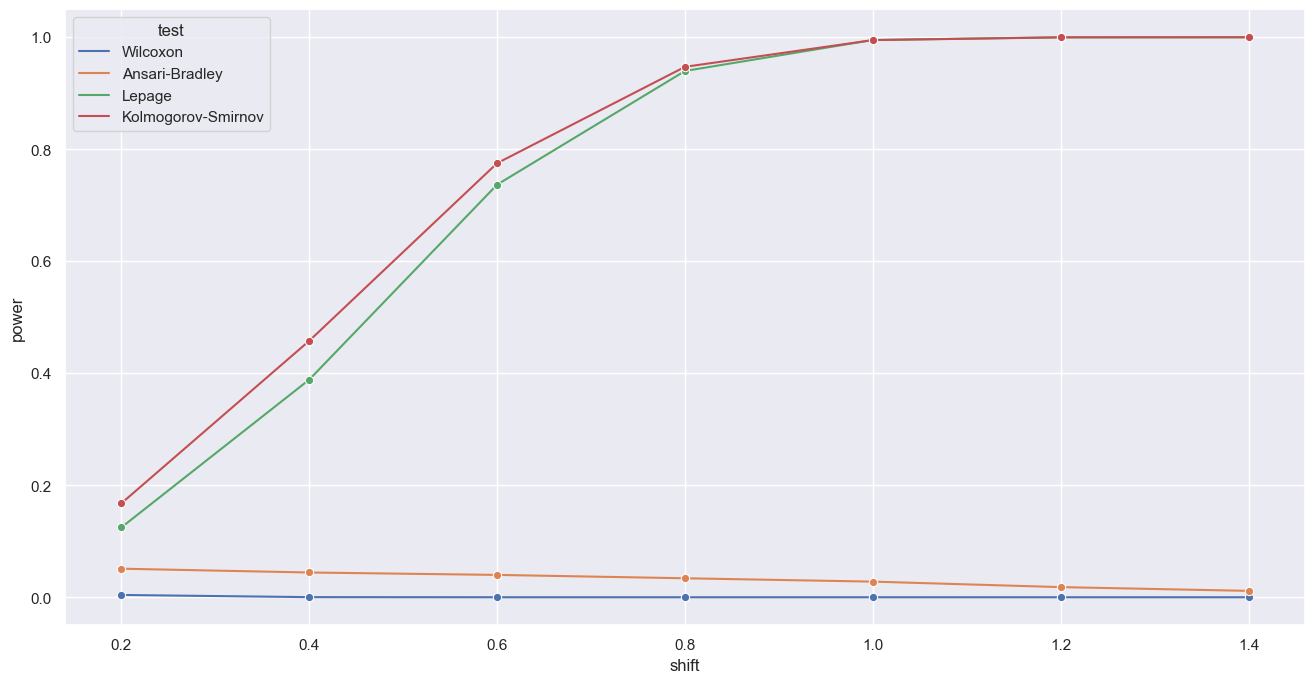

In [ ]:
print("Normal distribution with respective shift and scale parameters")
sns.lineplot(data=powers, x='shift', y='power', hue='test', marker='o')

## b)

In [ ]:
t_stat, powers = make_experiment(
    func=logistic.rvs,
    params=[
        ([0, 1], [0.2, 1.0]), ([0, 1], [0.4, 1.0]), ([0, 1], [0.6, 1.0]),
        ([0, 1], [0.8, 1.0]), ([0, 1], [1.0, 1.0]), ([0, 1], [1.2, 1.0]),
        ([0, 1], [1.4, 1.0])
    ],
    n=50,
    m=50
    )

In [ ]:
t_stat

,scale,shift,Wilcoxon,Ansari-Bradley,Lepage,Kolmogorov-Smirnov
0,1.0,0.2,0.7,0.983805,1.259904,0.7
1,1.0,0.4,0.9,-0.027713,0.249600,0.9
2,1.0,0.6,1.3,-1.385641,5.656368,1.3
3,1.0,0.8,1.7,-0.595825,3.331056,1.7
4,1.0,1.0,1.3,1.635056,5.868480,1.3
5,1.0,1.2,2.3,0.180133,18.602880,2.3
6,1.0,1.4,1.2,0.956092,2.628720,1.2


Logistic distribution with respective shift and scale parameters


<AxesSubplot: xlabel='shift', ylabel='power'>

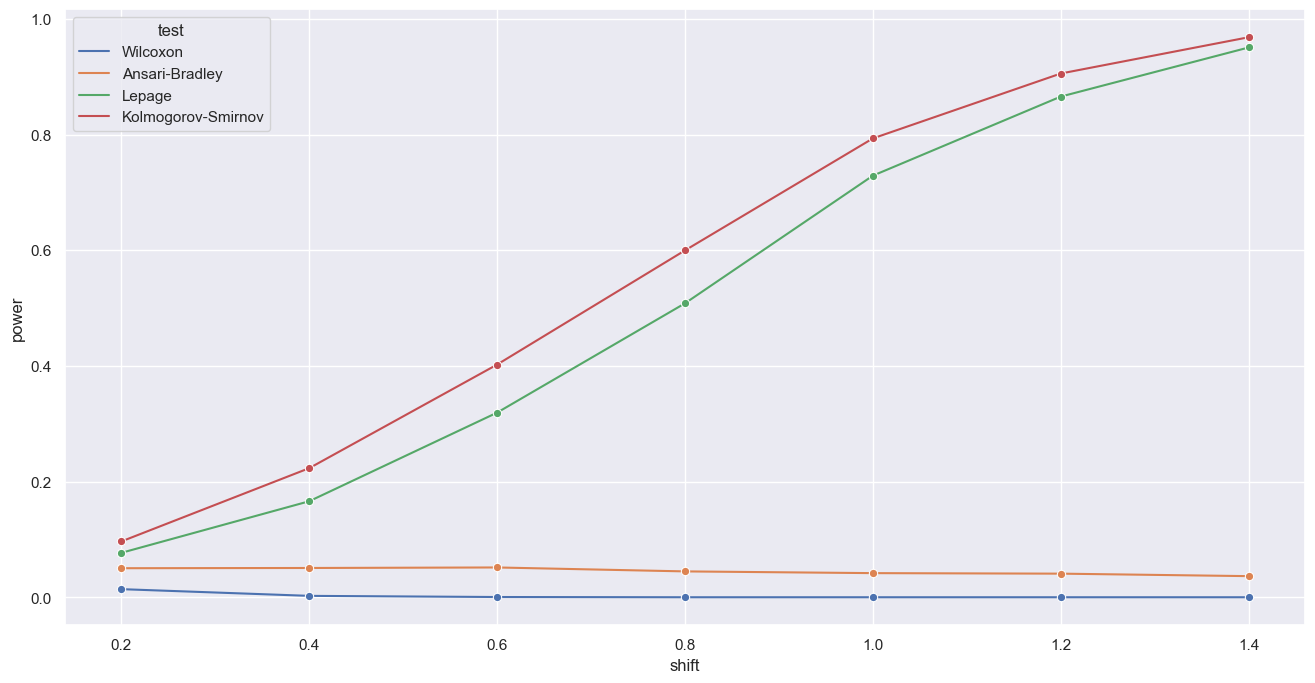

In [ ]:
print("Logistic distribution with respective shift and scale parameters")
sns.lineplot(data=powers, x='shift', y='power', hue='test', marker='o')

## c)

In [ ]:
t_stat, powers = make_experiment(
    func=cauchy.rvs,
    params=[
        ([0, 1], [0.0, 1.0]), ([0, 1], [0.5, 1.0]), ([0, 1], [1.0, 1.0]),
        ([0, 1], [1.5, 1.0]), ([0, 1], [2.0, 1.0]), ([0, 1], [2.5, 1.0]),
        ([0, 1], [3.0, 1.0])
    ],
    n=50,
    m=50
    )

In [ ]:
t_stat

,scale,shift,Wilcoxon,Ansari-Bradley,Lepage,Kolmogorov-Smirnov
0,1.0,0.0,1.9,-0.665108,8.084016,1.9
1,1.0,0.5,1.3,1.025374,5.371392,1.3
2,1.0,1.0,2.0,0.457261,6.603888,2.0
3,1.0,1.5,2.3,1.427210,19.259376,2.3
4,1.0,2.0,2.5,1.468779,13.823664,2.5
5,1.0,2.5,3.6,-1.122369,30.313344,3.6
6,1.0,3.0,3.5,0.498831,33.077424,3.5


Cauchy distribution with respective shift and scale parameters


<AxesSubplot: xlabel='shift', ylabel='power'>

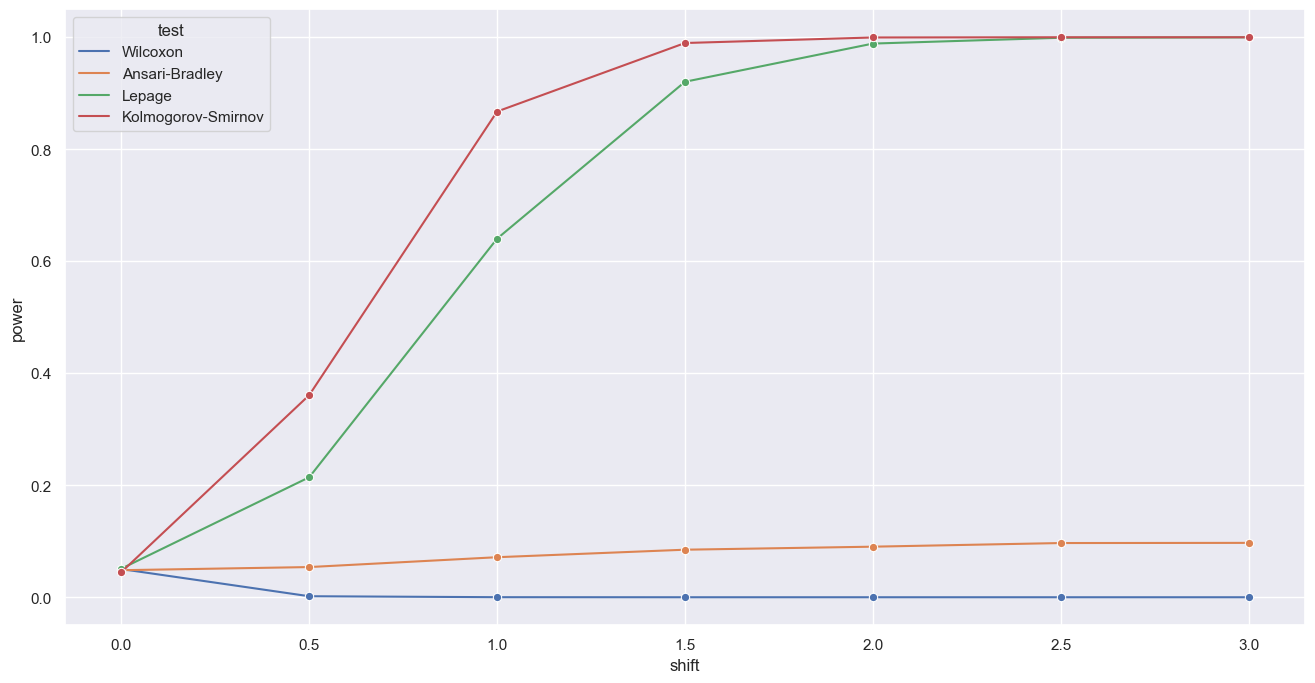

In [ ]:
print("Cauchy distribution with respective shift and scale parameters")
sns.lineplot(data=powers, x='shift', y='power', hue='test', marker='o')

## a)

In [ ]:
t_stat, powers = make_experiment(
    func=norm.rvs,
    params=[
        ([0, 1], [0, 1.0]), ([0, 1], [0, 1.5]), ([0, 1], [0, 2.0]),
        ([0, 1], [0, 2.5]), ([0, 1], [0, 3.0]), ([0, 1], [0, 3.5]),
        ([0, 1], [0, 4.0])
    ],
    n=50,
    m=50
    )

In [ ]:
t_stat

,scale,shift,Wilcoxon,Ansari-Bradley,Lepage,Kolmogorov-Smirnov
0,1.0,0,0.5,-0.193990,0.157632,0.5
1,1.5,0,0.8,2.147743,4.615152,0.8
2,2.0,0,1.5,4.711178,22.292400,1.5
3,2.5,0,1.3,3.658091,13.389744,1.3
4,3.0,0,2.0,5.958255,38.622000,2.0
5,3.5,0,1.6,6.152244,37.905600,1.6
6,4.0,0,1.9,4.822029,24.859440,1.9


Normal distribution with respective shift and scale parameters


<AxesSubplot: xlabel='scale', ylabel='power'>

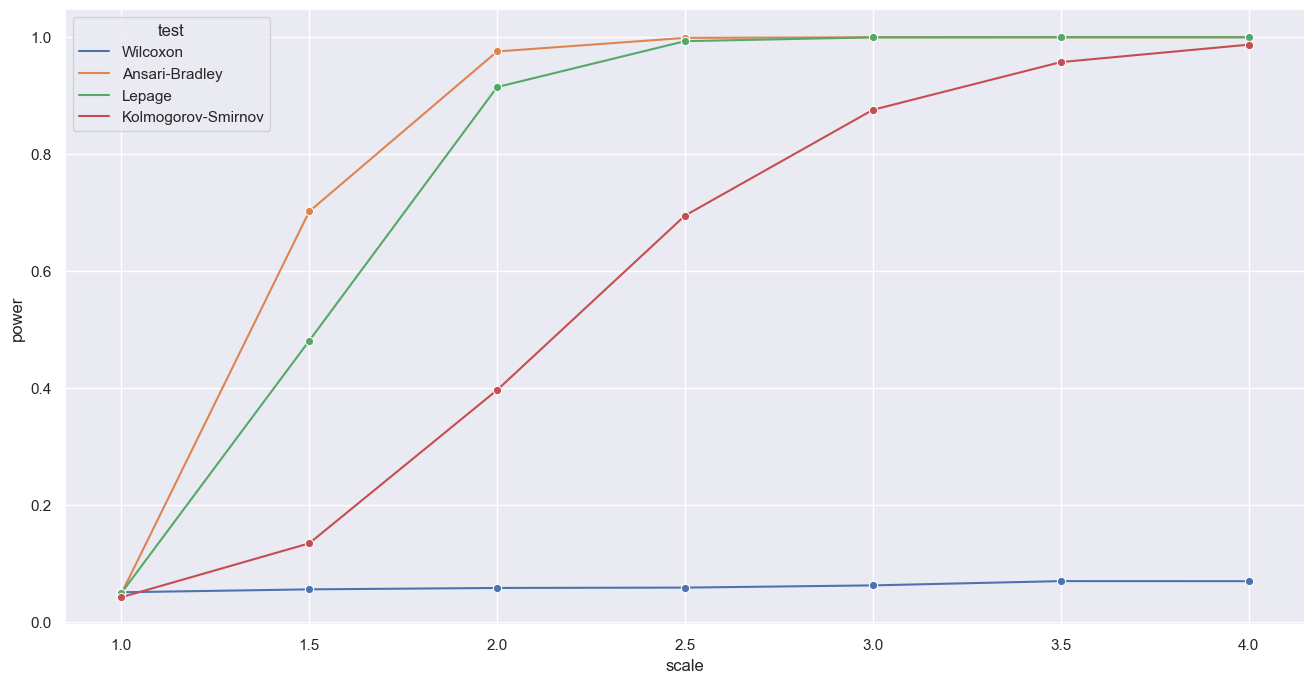

In [ ]:
print("Normal distribution with respective shift and scale parameters")
sns.lineplot(data=powers, x='scale', y='power', hue='test', marker='o')

## b)

In [ ]:
t_stat, powers = make_experiment(
    func=logistic.rvs,
    params=[
        ([0, 1], [0, 1.0]), ([0, 1], [0, 1.5]), ([0, 1], [0, 2.0]),
        ([0, 1], [0, 2.5]), ([0, 1], [0, 3.0]), ([0, 1], [0, 3.5]),
        ([0, 1], [0, 4.0])
    ],
    n=50,
    m=50
    )

In [ ]:
t_stat

,scale,shift,Wilcoxon,Ansari-Bradley,Lepage,Kolmogorov-Smirnov
0,1.0,0,0.8,1.080800,1.882560,0.8
1,1.5,0,0.8,2.036892,5.439936,0.8
2,2.0,0,1.0,2.701999,7.503600,1.0
3,2.5,0,1.4,3.865937,16.808304,1.4
4,3.0,0,1.4,4.849742,23.520048,1.4
5,3.5,0,2.0,5.362429,33.133440,2.0
6,4.0,0,1.7,4.863599,25.025520,1.7


Logistic distribution with respective shift and scale parameters


<AxesSubplot: xlabel='scale', ylabel='power'>

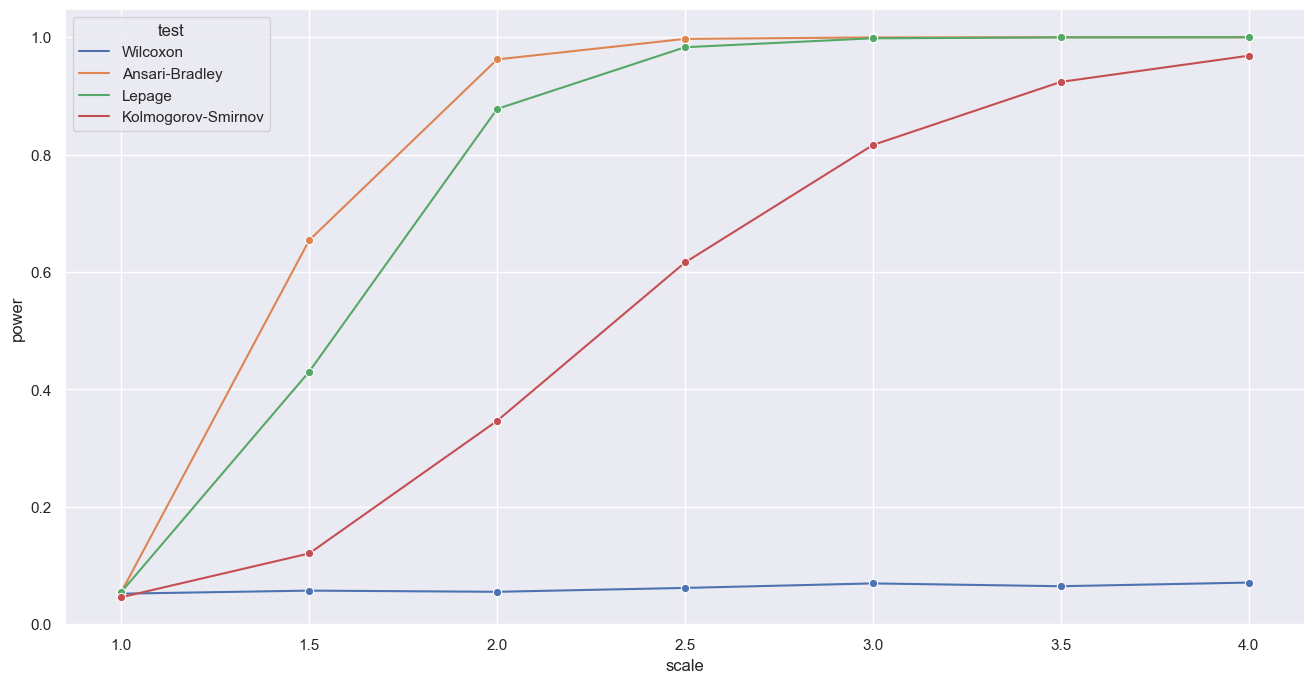

In [ ]:
print("Logistic distribution with respective shift and scale parameters")
sns.lineplot(data=powers, x='scale', y='power', hue='test', marker='o')

## c)

In [ ]:
t_stat, powers = make_experiment(
    func=cauchy.rvs,
    params=[
        ([0, 1], [0, 1.0]), ([0, 1], [0, 2.0]), ([0, 1], [0, 3.0]),
        ([0, 1], [0, 4.0]), ([0, 1], [0, 5.0]), ([0, 1], [0, 6.0]),
        ([0, 1], [0, 7.0])
    ],
    n=50,
    m=50
    )

In [ ]:
t_stat

,scale,shift,Wilcoxon,Ansari-Bradley,Lepage,Kolmogorov-Smirnov
0,1.0,0,0.8,0.318697,0.440256,0.8
1,2.0,0,1.3,2.937558,9.984000,1.3
2,3.0,0,1.1,3.505671,12.374400,1.1
3,4.0,0,1.7,4.461763,21.167040,1.7
4,5.0,0,1.7,5.819691,34.963248,1.7
5,6.0,0,1.7,4.531045,21.639360,1.7
6,7.0,0,2.0,5.902829,36.087600,2.0


Cauchy distribution with respective shift and scale parameters


<AxesSubplot: xlabel='scale', ylabel='power'>

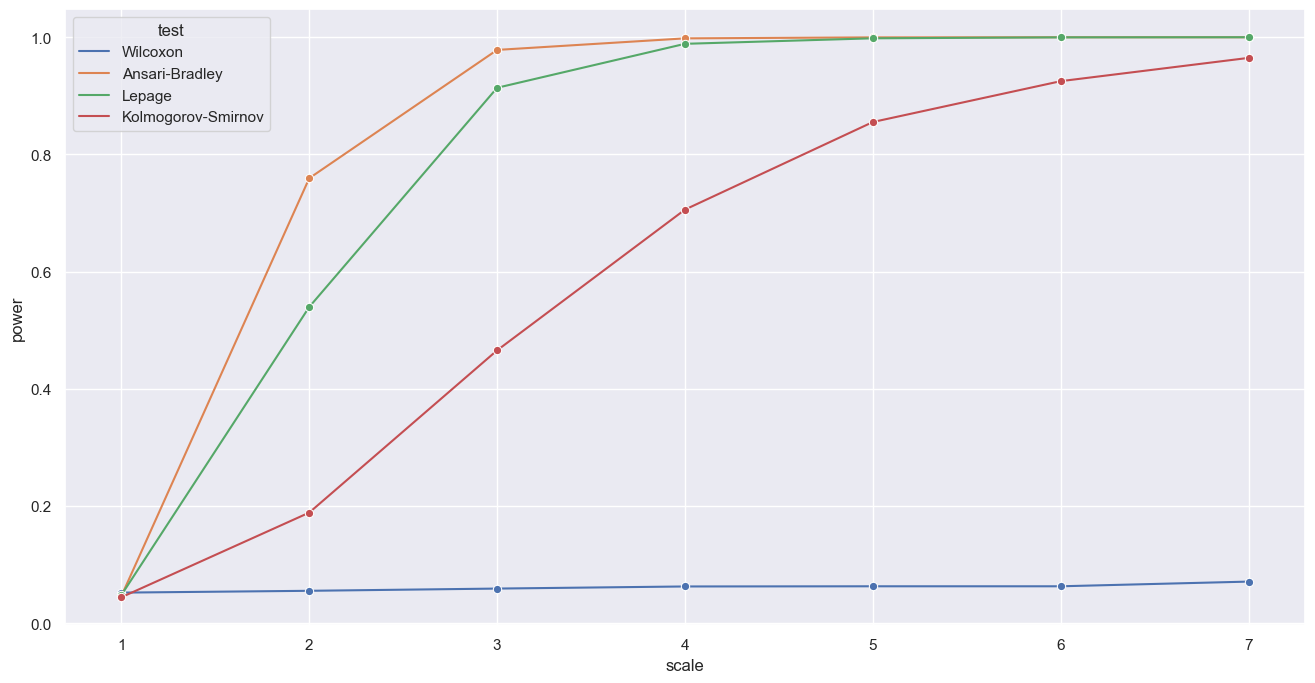

In [ ]:
print("Cauchy distribution with respective shift and scale parameters")
sns.lineplot(data=powers, x='scale', y='power', hue='test', marker='o')

## a)

In [ ]:
t_stat, powers = make_experiment(
    func=norm.rvs,
    params=[
        ([0, 1], [0.2, 1.0]), ([0, 1], [0.4, 1.5]), ([0, 1], [0.6, 2.0]),
        ([0, 1], [0.8, 2.5]), ([0, 1], [1.0, 3.0]), ([0, 1], [1.2, 3.5]),
        ([0, 1], [1.4, 4.0])
    ],
    n=50,
    m=50
    )

In [ ]:
t_stat

,scale,shift,Wilcoxon,Ansari-Bradley,Lepage,Kolmogorov-Smirnov
0,1.0,0.2,0.9,0.415692,1.355952,0.9
1,1.5,0.4,1.0,1.344071,2.532720,1.0
2,2.0,0.6,1.4,3.713517,14.913840,1.4
3,2.5,0.8,1.9,5.126870,29.119152,1.9
4,3.0,1.0,2.1,3.907507,21.454896,2.1
5,3.5,1.2,1.6,5.750409,33.473472,1.6
6,4.0,1.4,1.8,5.071445,26.343360,1.8


Normal distribution with respective shift and scale parameters


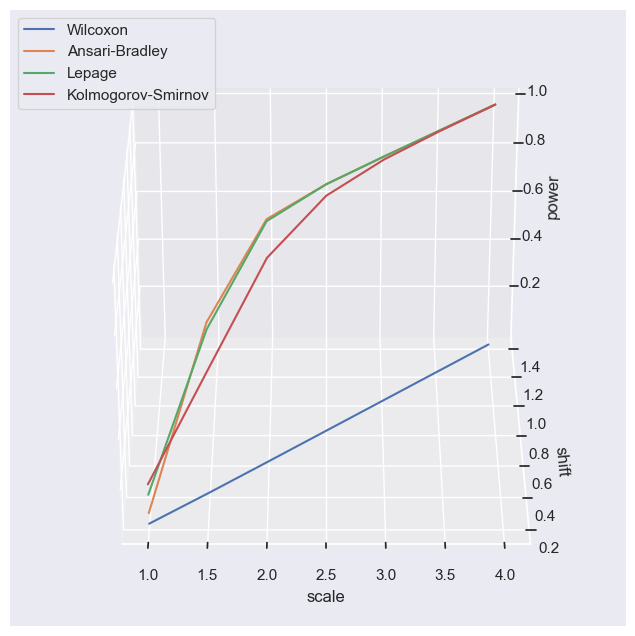

In [ ]:
print("Normal distribution with respective shift and scale parameters")
ax = plt.figure().add_subplot(projection='3d')

for test in ['Wilcoxon', 'Ansari-Bradley', 'Lepage', 'Kolmogorov-Smirnov']:
    data = powers[powers.test == test]
    x = list(data.scale)
    y = list(data['shift'])
    z = list(data.power)
    ax.plot(x, y, z, label=test)

ax.legend()
ax.set_xlabel('scale')
ax.set_ylabel('shift')
ax.set_zlabel('power')
ax.view_init(elev=30., azim=-90, roll=0)
plt.show ()

## b)

In [ ]:
t_stat, powers = make_experiment(
    func=logistic.rvs,
    params=[
        ([0, 1], [0.2, 1.0]), ([0, 1], [0.4, 1.5]), ([0, 1], [0.6, 2.0]),
        ([0, 1], [0.8, 2.5]), ([0, 1], [1.0, 3.0]), ([0, 1], [1.2, 3.5]),
        ([0, 1], [1.4, 4.0])
    ],
    n=50,
    m=50
    )

In [ ]:
t_stat

,scale,shift,Wilcoxon,Ansari-Bradley,Lepage,Kolmogorov-Smirnov
0,1.0,0.2,0.9,0.956092,1.149312,0.9
1,1.5,0.4,1.1,2.812851,8.382576,1.1
2,2.0,0.6,1.3,2.812851,8.492928,1.3
3,2.5,0.8,2.1,4.683465,25.833648,2.1
4,3.0,1.0,2.2,5.196152,30.320112,2.2
5,3.5,1.2,2.6,4.808173,32.453616,2.6
6,4.0,1.4,1.7,6.027537,36.419952,1.7


Logistic distribution with respective shift and scale parameters


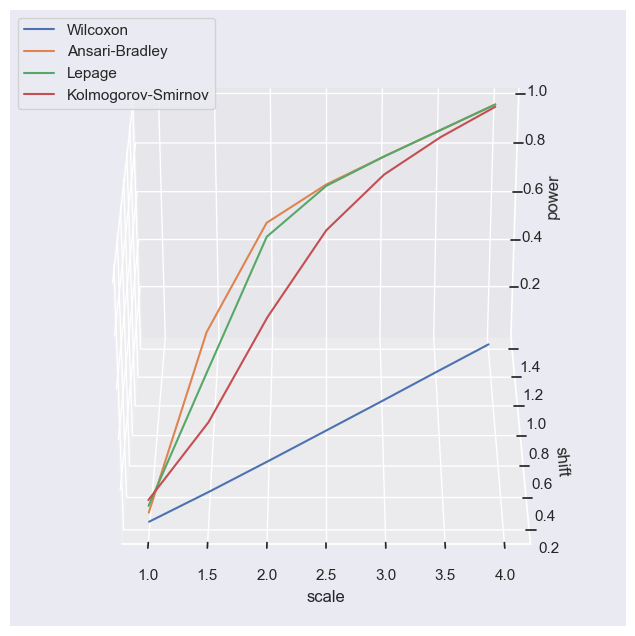

In [ ]:
print("Logistic distribution with respective shift and scale parameters")
ax = plt.figure().add_subplot(projection='3d')

for test in ['Wilcoxon', 'Ansari-Bradley', 'Lepage', 'Kolmogorov-Smirnov']:
    data = powers[powers.test == test]
    x = list(data.scale)
    y = list(data['shift'])
    z = list(data.power)
    ax.plot(x, y, z, label=test)

ax.legend()
ax.set_xlabel('scale')
ax.set_ylabel('shift')
ax.set_zlabel('power')
ax.view_init(elev=30., azim=-90, roll=0)
plt.show ()

## c)

In [ ]:
t_stat, powers = make_experiment(
    func=cauchy.rvs,
    params=[
        ([0, 1], [0, 1.0]), ([0, 1], [0.5, 2.0]), ([0, 1], [1.0, 3.0]),
        ([0, 1], [1.5, 4.0]), ([0, 1], [2.0, 5.0]), ([0, 1], [2.5, 6.0]),
        ([0, 1], [3.0, 7.0])
    ],
    n=50,
    m=50
    )

In [ ]:
t_stat

,scale,shift,Wilcoxon,Ansari-Bradley,Lepage,Kolmogorov-Smirnov
0,1.0,0.0,1.3,-0.928379,6.641520,1.3
1,2.0,0.5,0.9,2.577292,6.857904,0.9
2,3.0,1.0,1.5,3.713517,14.744496,1.5
3,4.0,1.5,1.2,3.270112,11.024304,1.2
4,5.0,2.0,1.2,3.644235,13.391040,1.2
5,6.0,2.5,2.1,6.928203,48.849072,2.1
6,7.0,3.0,2.4,5.902829,38.163504,2.4


Cauchy distribution with respective shift and scale parameters


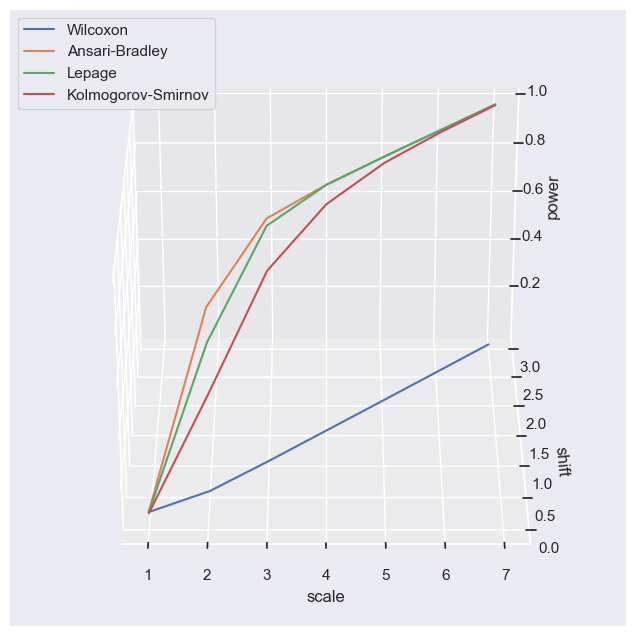

In [ ]:
print("Cauchy distribution with respective shift and scale parameters")
ax = plt.figure().add_subplot(projection='3d')

for test in ['Wilcoxon', 'Ansari-Bradley', 'Lepage', 'Kolmogorov-Smirnov']:
    data = powers[powers.test == test]
    x = list(data.scale)
    y = list(data['shift'])
    z = list(data.power)
    ax.plot(x, y, z, label=test)

ax.legend()
ax.set_xlabel('scale')
ax.set_ylabel('shift')
ax.set_zlabel('power')
ax.view_init(elev=30., azim=-90, roll=0)
plt.show ()